# Whether-Weather-Drives-Crime
## Analytics with Python (Matplotlib, Pandas, and API Requests)
### Data Analytics Bootcamp - Project 1 - Group 7

#### Team Members
Minna Wu<br>
Tim Sutherland<br>
Wenjie Shao<br>
Gobind Singh<br>

#### Project Description 
We are interested in seeing whether there is a correlation weather and the number of major crimes commited. For this project, we decided to look at just the City of Toronto.
 
#### Research Questions to Answer 
Is there a correlation between weather and major crimes?<br>
- Temperature vs. crime
- Weekend or weekday vs. crime
- Precipitation vs. crime
- Moon phase vs. crime

#### Data Sets to be Used
2 APIs:
- MCI (Major Crime Indicators) 2014-2017 (http://data.torontopolice.on.ca/datasets/mci-2014-to-2017/geoservice)
- World Weather Online (https://www.worldweatheronline.com/developer/premium-api-explorer.aspx)

#### Rough Breakdown of Tasks
Minna Wu: Pulling and cleaning of Weather Data<br>
Wenjie Shao: Pulling and cleaning of Crime Data<br>
Gobind Singh:  Preparing data using Pandas<br>
Tim Sutherland: Plotting charts and final analysis write-up<br>

In [325]:
# Dependencies
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
import seaborn as sb
import scipy.stats as stats

## Pulling and Cleaning Crime Data

In [2]:
# Set up query url
base_url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_2017/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

In [3]:
# Prepare lists for storing crime data
date_of_crime = []
day_of_week_crime = []
crime_type_list = []

# Setup offset variable (2000 records max in each pull but >130,000 records in total)
total_pulls = math.ceil(131073/2000) # 66

for pull_num in range(total_pulls):
    
    offset_num = pull_num*2000
    url = f"{base_url}&resultOffset={offset_num}"
    crime_data = requests.get(url).json()
    
    for i in range(len(crime_data['features'])):
        
        # Convert occurrence date to match weather date
        day = str(crime_data['features'][i]['attributes']['occurrenceday'])
        if day.isnumeric():
            if int(day) < 10:
                formatted_day = '0' + str(day)
            else:
                formatted_day = str(day)
        else: # if date record is missing
            continue

        month = crime_data['features'][i]['attributes']['occurrencemonth']
        month_dict = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05',\
                    'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10',\
                    'November':'11', 'December':'12'}
        formatted_month = month_dict[month]
        year = crime_data['features'][i]['attributes']['occurrenceyear']

        # Exclude dates outside of 2014 to 2017 range (since MCI 2014-2017 has some records prior to 2014)
        if year < 2014:
            continue

        formatted_date = f"{year}-{formatted_month}-{formatted_day}"
        #print(formatted_date)
        date_of_crime.append(formatted_date)

        # Weekday
        weekday = crime_data['features'][i]['attributes']['occurrencedayofweek']
        day_of_week_crime.append(weekday)

        # Type of Crime (MCI)
        crime_type = crime_data['features'][i]['attributes']['MCI']
        crime_type_list.append(crime_type)

# Store lists into a dataframe
crime_df = pd.DataFrame({'Date': date_of_crime,
                         'Day_of_week': day_of_week_crime,
                         'Type': crime_type_list})

crime_df.head()

,Date,Day_of_week,Type
0,2014-01-25,Saturday,Assault
1,2014-01-25,Saturday,Assault
2,2014-01-25,Saturday,Assault
3,2014-01-25,Saturday,Break and Enter
4,2014-01-25,Saturday,Break and Enter


In [4]:
crime_df.count()

Date           130167
Day_of_week    130167
Type           130167
dtype: int64

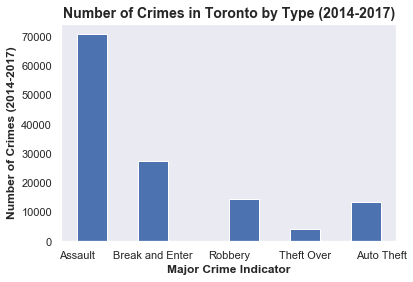

In [5]:
# Histogram by Type of Crime
sb.set()
plt.hist(crime_type_list)
plt.title('Number of Crimes in Toronto by Type (2014-2017)', fontsize = 14, fontweight = 'bold')
plt.xlabel('Major Crime Indicator', fontweight = 'bold')
plt.ylabel('Number of Crimes (2014-2017)', fontweight = 'bold')
plt.grid()
plt.show()

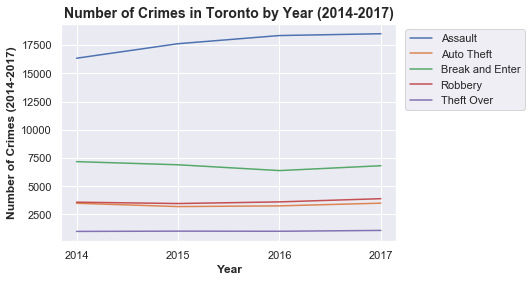

,2014,2015,2016,2017
Type,,,,
Assault,16339,17624,18347,18507
Auto Theft,3488,3194,3256,3497
Break and Enter,7175,6898,6383,6813
Robbery,3583,3464,3609,3893
Theft Over,993,1017,1006,1081


In [32]:
# Prepare data for plotting number of crimes by year
crimes_2014 = crime_df[crime_df.Date.str.startswith('2014')] # 31578 records
crimes_2015 = crime_df[crime_df.Date.str.startswith('2015')] # 32197 records
crimes_2016 = crime_df[crime_df.Date.str.startswith('2016')] # 32601 records
crimes_2017 = crime_df[crime_df.Date.str.startswith('2017')] # 33791 records
num_crimes_2014 = crimes_2014.groupby('Type').count()['Date'] 
num_crimes_2015 = crimes_2015.groupby('Type').count()['Date']
num_crimes_2016 = crimes_2016.groupby('Type').count()['Date']
num_crimes_2017 = crimes_2017.groupby('Type').count()['Date']
crime_type_by_year_df = pd.DataFrame({'2014': num_crimes_2014,
                                     '2015': num_crimes_2015,
                                     '2016': num_crimes_2016,
                                     '2017': num_crimes_2017})

# Create Line Plot of the Number of Crimes By Year
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(crime_type_by_year_df.T)
plt.title('Number of Crimes in Toronto by Year (2014-2017)', fontsize = 14, fontweight = 'bold')
plt.xlabel('Year', fontweight = 'bold')
plt.ylabel('Number of Crimes (2014-2017)', fontweight = 'bold')
leg = plt.legend(crime_type_by_year_df.index, loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend
xOffset = 0.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()
crime_type_by_year_df

## Pulling and Cleaning Weather Data

In [7]:
# WWO apikey
apikey = "56b161f544224f85b0e180450181711"

In [73]:
# Prepare lists for storing weather data
date_list = []
temp_list = []
moon_list = []
rain_list = []
years_of_interest = ['2014', '2015', '2016', '2017']
months_of_interest = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
last_day_of_month = ['31', '28', '31', '30', '31', '30', '31', '31', '30', '31', '30', '31']

for year in years_of_interest:
    for i in range(12):
        
        # Prepare start and end dates for query
        start_date = f"{year}-{months_of_interest[i]}-01"
        end_date = f"{year}-{months_of_interest[i]}-{last_day_of_month[i]}"
        
        # Prepare url (24hr average)
        weather_url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={apikey}&q=Toronto&format=json&date={start_date}&enddate={end_date}&tp=24"
        
        # Request and store json data
        data = requests.get(weather_url).json()
        
        for day in range(len(data['data']['weather'])):
            # Date
            date_list.append(data['data']['weather'][day]['date'])

            # Temperature
            temp_list.append(data['data']['weather'][day]['hourly'][0]['tempC'])

            # Precipitation
            rain_list.append(data['data']['weather'][day]['hourly'][0]['precipMM'])

            # Moon_phase
            moon_list.append(data['data']['weather'][day]['astronomy'][0]['moon_phase'])

# Store lists into a dataframe
weather_df = pd.DataFrame({'Date': date_list,
                          'Temp': temp_list,
                          'Precip': rain_list,
                          'Moon Phase': moon_list})

# Convert Temp and Precip in dataframe to floats
weather_df['Temp'] = pd.to_numeric(weather_df['Temp'], errors='ignore')
weather_df['Precip'] = pd.to_numeric(weather_df['Precip'], errors='ignore')

weather_df.head()

,Date,Temp,Precip,Moon Phase
0,2014-01-01,-8,0.9,Waning Crescent
1,2014-01-02,-13,3.1,Waning Crescent
2,2014-01-03,-14,0.2,Waning Crescent
3,2014-01-04,2,0.5,Waning Crescent
4,2014-01-05,2,12.5,Waning Crescent


In [102]:
# Merge weather and crime dataframes, dropping crime records with no matching weather data (i.e. Feb 29, 2016)
weather_crime_df = pd.merge(crime_df,weather_df,how='left', on='Date').dropna()
weather_crime_df.head()

,Date,Day_of_week,Type,Temp,Precip,Moon Phase
0,2014-01-25,Saturday,Assault,-1.0,3.1,Waning Gibbous
1,2014-01-25,Saturday,Assault,-1.0,3.1,Waning Gibbous
2,2014-01-25,Saturday,Assault,-1.0,3.1,Waning Gibbous
3,2014-01-25,Saturday,Break and Enter,-1.0,3.1,Waning Gibbous
4,2014-01-25,Saturday,Break and Enter,-1.0,3.1,Waning Gibbous


## 1. Temperature vs. Crime

In [230]:
# Create bins for temperature data
temp_bins = [-100, -10, 0, 10, 20, 30, 100]
temp_labels = ["-100 to -10", "-10 to 0", "0 to 10", "10 to 20", "20 to 30", "30 to 100"]

# Bin the Temp column and add it to the dataframe as the Temp. Bin column
weather_crime_df['Temp Bin'] = pd.cut(weather_crime_df['Temp'], temp_bins, labels=temp_labels)

# Preview dataframe
weather_crime_df[['Date', 'Temp Bin']]

,Date,Temp Bin
0,2014-01-25,-10 to 0
1,2014-01-25,-10 to 0
2,2014-01-25,-10 to 0
3,2014-01-25,-10 to 0
4,2014-01-25,-10 to 0
5,2014-01-25,-10 to 0
6,2014-01-25,-10 to 0
7,2014-01-26,-100 to -10
8,2014-01-27,-10 to 0
9,2014-01-26,-100 to -10


In [221]:
# Group by temperature bins, counting the number of crimes committed in each bucket
grouped_by_temp_bins = weather_crime_df.groupby(['Temp Bin', 'Type'])['Date'].count()

# Create a Dataframe with the grouped temperature data and reset index for plotting
grouped_by_temp_bins_df = pd.DataFrame(grouped_by_temp_bins.reset_index())

# Rename columns
grouped_by_temp_bins_df.columns = ['Temp Bin', 'Crime Type', 'Number of Crimes']

# Pivot Dataframe as preparation for plotting
grouped_by_temp_bins_df2 = grouped_by_temp_bins_df.pivot(index='Temp Bin', columns='Crime Type', values = 'Number of Crimes')

# Preview Dataframe
grouped_by_temp_bins_df2

Crime Type,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
Temp Bin,,,,,
-100 to -10,1308,236,534,267,60
-10 to 0,9037,1730,3554,1854,510
0 to 10,19621,3666,7765,4002,1089
10 to 20,15705,3044,6206,3422,987
20 to 30,21718,4127,8073,4352,1236
30 to 100,3377,625,1126,647,210


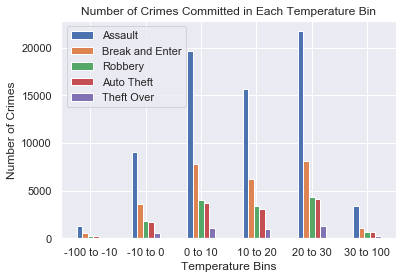

In [309]:
# Plot Count of Each Crime Type For Each Temperature Bin
fig = plt.figure()
ax = fig.add_subplot(111)

xloc = np.arange(6)  # the x locations for the groups
width = 0.1      # the width of the bars

ax.set(title = 'Number of Crimes Committed in Each Temperature Bin', xlabel = 'Temperature Bins', ylabel = 'Number of Crimes')
ax.bar(xloc - width*2, grouped_by_temp_bins_df2['Assault'], width, label = 'Assault')
ax.bar(xloc - width, grouped_by_temp_bins_df2['Break and Enter'], width, label = 'Break and Enter')
ax.bar(xloc, grouped_by_temp_bins_df2['Robbery'], width, label = 'Robbery')
ax.bar(xloc + width, grouped_by_temp_bins_df2['Auto Theft'], width, label = 'Auto Theft')
ax.bar(xloc + width*2, grouped_by_temp_bins_df2['Theft Over'], width, label = 'Theft Over')
plt.xticks(xloc, temp_labels)
ax.legend()
plt.show()

#### *But there might just be more days with these temperatures!*

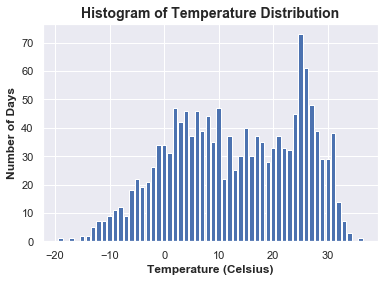

In [316]:
# Group weather dataframe by temperature bins, counting the number of days in each bucket
num_days_in_temp_bins = weather_df.groupby(['Temp'])['Date'].count()

# Plot bar graph of temperature distribution
plt.title('Histogram of Temperature Distribution', fontweight = 'bold', fontsize = 14)
plt.xlabel('Temperature (Celsius)', fontweight = 'bold')
plt.ylabel('Number of Days', fontweight = 'bold')
plt.bar(num_days_in_temp_bins.index, num_days_in_temp_bins)
plt.show()

## Temperature vs. *Average* Crime

We have different amounts of crime happening each day. So if we divide the total
number of crimes committed within a temperature bin by the number of days between
2014 and 2017 wihtin that temperature bin, we should get an average of the number
of crimes committed during days within that temperature range.

Previously, we counted the number of crimes committed in each temperature range and the number of days at each temperature. Now, we will calculate the number of crimes committed at each day with the same average temperature. Finally, we will divide the number of crimes at each temperature by the number of days with that temperature.

In [287]:
# Group weather-crime dataframe by temperature bins, 
#  counting the number of crimes committed in each bucket
num_crimes_in_temp_bins = weather_crime_df.groupby(['Temp'])['Type'].count()

# Create a Dataframe with the grouped temperature data
num_crimes_in_temp_bins_df = pd.DataFrame({'Number of Crimes': num_crimes_in_temp_bins,
                                           'Number of Days': num_days_in_temp_bins,
                                           'Average Number of Crimes Committed': round(num_crimes_in_temp_bins/num_days_in_temp_bins)})

# Preview Dataframe
num_crimes_in_temp_bins_df

,Number of Crimes,Number of Days,Average Number of Crimes Committed
Temp,,,
-19.0,77,1,77.0
-17.0,90,1,90.0
-15.0,154,2,77.0
-14.0,121,2,60.0
-13.0,335,5,67.0
-12.0,534,7,76.0
-11.0,431,7,62.0
-10.0,663,9,74.0
-9.0,832,11,76.0


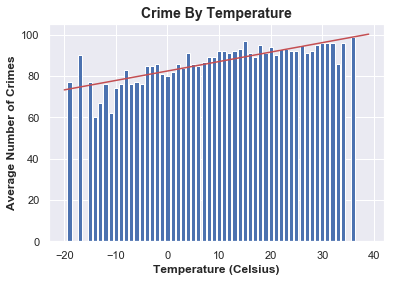

R-Squared = 0.656
p-value = 2.1317514954167793e-13


In [362]:
# Plot bar graph of average number of crimes committed at each temperature
plt.title('Crime By Temperature', fontweight = 'bold', fontsize = 14)
plt.xlabel('Temperature (Celsius)', fontweight = 'bold')
plt.ylabel('Average Number of Crimes', fontweight = 'bold')
plt.bar(num_crimes_in_temp_bins_df.index, num_crimes_in_temp_bins_df['Average Number of Crimes Committed'])

# Plot line of best fit
slope, intercept, rvalue, pvalue, _ = stats.linregress(num_crimes_in_temp_bins_df.index, num_crimes_in_temp_bins_df['Average Number of Crimes Committed'])
x = np.arange(-20, 40)
y = slope*x + intercept
plt.plot(x, y, color = 'r')
plt.show()

# Print R-Squared
print(f"R-Squared = {round(rvalue**2,3)}")
print(f"p-value = {pvalue}")

## Check Significance Using One Sample T-Test

The One Sample T Test compares a sample mean to a hypothesized population mean to determine whether the two means are significantly different.

In [341]:
# Calculate average temperature overall
overall_average_temp = weather_df['Temp'].mean()
print(f"Average Temperature from 2014 to 2017:\n{overall_average_temp}")

# Check averages of temperature on days when crime was committed
grouped_by_crime_bins_df = pd.DataFrame({'Average Temperature': weather_crime_df.groupby('Type')['Temp'].mean()})
grouped_by_crime_bins_df

Average Temperature from 2014 to 2017:
13.00068493150685


,Average Temperature
Type,
Assault,13.705946
Auto Theft,13.789619
Break and Enter,13.343972
Robbery,13.552118
Theft Over,13.990225


In [345]:
# One sample t-test
_, pvalue = stats.ttest_1samp(grouped_by_crime_bins_df, overall_average_temp)
print(f"p-value = {round(pvalue[0], 3)}")

p-value = 0.003


### Conclusion
There is a significant effect of temperature on crime rate. Warmer temperatures correlate with more crime incidents. However, a hike in crime is observed at 14 degrees Celsius, which is a lower temperature than one would imagine.

## Moon Phase vs. Crime

In [357]:
weather_crime_df.head()

,Date,Day_of_week,Type,Temp,Precip,Moon Phase,Temp Bin
0,2014-01-25,Saturday,Assault,-1.0,3.1,Waning Gibbous,-10 to 0
1,2014-01-25,Saturday,Assault,-1.0,3.1,Waning Gibbous,-10 to 0
2,2014-01-25,Saturday,Assault,-1.0,3.1,Waning Gibbous,-10 to 0
3,2014-01-25,Saturday,Break and Enter,-1.0,3.1,Waning Gibbous,-10 to 0
4,2014-01-25,Saturday,Break and Enter,-1.0,3.1,Waning Gibbous,-10 to 0
